<p style="font-size:14pt;text-align:center;">
Training Fast R-CNN network on PascalVOC 2005.
</p>

In [140]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, hsv2rgb

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params, set_all_param_values
    
import bnr_ml.objectdetect.fastrcnn as fastrcnn
import bnr_ml.utils.helpers as helpers

import pdb

In [128]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [131]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'motorbike' in obj['label'].lower():
                obj['label'] = 'bike'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bicycle'
            else:
                print obj

In [132]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 0:
                counts[0] += 1
            elif obj['label'] == 1:
                counts[1] += 1
            elif obj['label'] == 2:
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [133]:
def get_num_from_label(obj):
    lab = obj['label'].lower()
    if 'car' == lab:
        obj['label'] = 0
    elif 'bicycle' == lab:
        obj['label'] = 1
    elif 'bike' == lab:
        obj['label'] = 2
    elif 'person' == lab:
        obj['label'] = 3
    else:
        obj['label'] = 4
    return obj

In [134]:
def fix_obj(obj):
    x, y = obj['p1'][0], obj['p1'][1]
    w, h = obj['p2'][0] - x, obj['p2'][1] - y
    obj['x'], obj['y'], obj['w'], obj['h'] = x, y, w, h
    del obj['p1'], obj['p2']
    return get_num_from_label(obj)

In [135]:
add_proper_labels(annotations)

In [136]:
annotations = [[fix_obj(obj) for obj in objs] for objs in annotations]

In [137]:
annotations = np.asarray(annotations)

In [138]:
counts = get_label_counts(annotations)

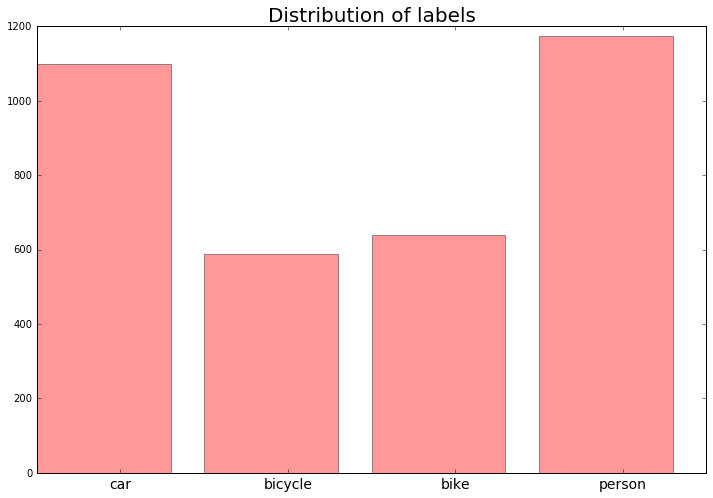

In [139]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [12]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [13]:
with open('indices.pkl', 'rb') as f:
    indices = pk.load(f)
    train_idx = indices['train_index']
    test_idx = indices['test_index']

In [14]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

<b>Fix annotations so that you can use the static method for generating data for fast r-cnn.</b>

<b>Now we define the net for recognition.</b>

In [15]:
num_epochs = 1000
batch_size = 50

In [16]:
num_classes = 4

In [17]:
input_shape = (224,224)
net = {}
net['input'] = InputLayer((None,3) + input_shape)
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['conv7'] = Conv2DLayer(net['conv6'], 64, (1,1))
net['pool3'] = Pool2DLayer(net['conv7'], (2,2))
net['conv8'] = Conv2DLayer(net['pool3'], 128, (3,3))
net['conv9'] = Conv2DLayer(net['conv8'], 128, (3,3))
net['conv10'] = Conv2DLayer(net['conv9'], 128, (1,1))
net['pool4'] = Pool2DLayer(net['conv10'], (2,2))
net['conv11'] = Conv2DLayer(net['pool4'], 128, (3,3))
net['conv12'] = Conv2DLayer(net['conv11'], 128, (3,3))
net['conv13'] = Conv2DLayer(net['conv12'], 128, (1,1))


net['dense1'] = DenseLayer(dropout(net['conv13'], p=.5), 2048)
# net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), 2048)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.5), (2 * 5 + 4) * (6*6))
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Load pre-trained weights</b>

In [18]:
load_pretrained = True
if load_pretrained:
    with open('pretrained_weights_2.pkl', 'rb') as f:
        weights = pk.load(f)
        lasagne.layers.set_all_param_values(net['output'], weights)

<b>Add extra layers to network for detection</b>

In [19]:
net['detect'] = net['output']
net['localize'] = DenseLayer(dropout(net['dense2'], p=.5), (num_classes + 1) * 4)

In [174]:
load_weights = True
if load_weights:
    with open('fastrcnn_weights.pkl', 'rb') as f:
        params = pk.load(f)
        tmp = params[:-4]
        tmp.extend(params[-2:])
        set_all_param_values(net['detect'], params[:-2])
        set_all_param_values(net['localize'], tmp)

<b>Train the network

In [189]:
reload(fastrcnn)

<module 'bnr_ml.objectdetect.fastrcnn' from '/usr/local/python/bnr_ml/objectdetect/fastrcnn.py'>

In [190]:
detector = fastrcnn.FastRCNNDetector(net, num_classes)

In [ ]:
print_obj = helpers.NotebookPrinter(open('/dev/stdout', 'w'), sys.stdout)

In [ ]:
train_gen = fastrcnn.FastRCNNDetector.generate_data(train_annotations, input_shape, num_classes, num_rios=5, per_batch=10)
test_gen = fastrcnn.FastRCNNDetector.generate_data(test_annotations, input_shape, num_classes, num_rios=5, per_batch=10)
train_loss, test_loss = detector.train(
    train_gen,
    test_gen,
    print_obj,
    lr=1e-5,
    lmbda=1.
)

Getting cost...
Compiling...
Compiling took 22.261 seconds
Beginning training
Batch error: 0.4577
Batch error: 0.5883
Batch error: 0.5546
Batch error: 0.5157
Batch error: 0.7612
Batch error: 0.8902
Batch error: 0.7667
Batch error: 0.4514
Batch error: 0.7027
Batch error: 0.8154
Batch error: 0.9790
Batch error: 0.8463
Batch error: 0.7680
Batch error: 0.5516
Batch error: 0.4153
Batch error: 0.6324
Batch error: 0.5636
Batch error: 0.4746
Batch error: 0.8198
Batch error: 0.6687
Batch error: 0.5737
Batch error: 0.4309
Batch error: 0.5158
Batch error: 0.4801
Batch error: 0.4747
Batch error: 0.5284
Batch error: 0.5788
Batch error: 0.5399
Batch error: 0.5258
Batch error: 0.5467
Batch error: 0.5079
Batch error: 0.4980
Batch error: 0.5342
Batch error: 0.4952
Batch error: 0.7391
Batch error: 0.7172
Batch error: 0.6119
Batch error: 0.8310
Batch error: 0.4450
Batch error: 0.7037
Batch error: 0.7227


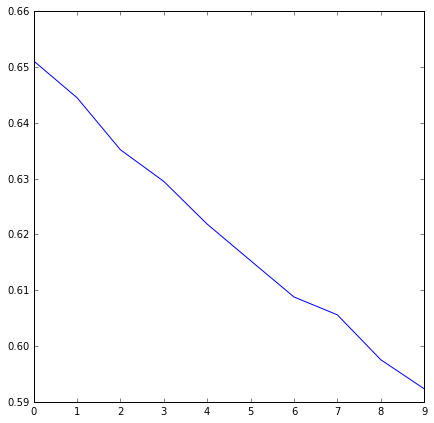

In [182]:
plt.figure(figsize=(7,7))
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')

plt.show()

/usr/local/python/bnr_ml/data/PascalVOC/VOC2005_2/PNGImages/INRIA_inria-person-train/crop001672.png


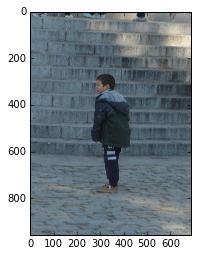

In [183]:
im = test_annotations[int(test_annotations.__len__()*np.random.rand())][0]['image']
print im
im = imread(im)
plt.imshow(im)

In [184]:
detector.detect_im(im)

(array([ 0.00851582,  0.05409773,  0.00298049,  0.11788096,  0.81652492], dtype=float32),
 array([ 0.        ,  0.00689692,  1.        ,  1.        ], dtype=float32))

In [103]:
with open('fastrcnn_weights.pkl', 'wb') as f:
    params = [p.get_value() for p in detector.params]
    pk.dump(params, f)